In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import datetime
import time
import os
import seaborn as sns
scaler = MinMaxScaler()

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda:0

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
def data_pep(df, feat_col_idx, target_col_idx, seq_len=10):
    X_out = []
    y_out = []
    X = df[:, feat_col_idx]
    y = df[:, target_col_idx]

    start_idx = 0
    end_idx = seq_len
    length = len(df)

    while end_idx <= length:
        X_seq = X[start_idx:end_idx].reshape(seq_len, -1, 1)
        y_seq = y[end_idx-1]
        X_out.append(X_seq)
        y_out.append(y_seq)
        start_idx += seq_len
        end_idx += seq_len

    X_out = np.array(X_out)
    y_out = np.array(y_out)
    
    return X_out, y_out

In [4]:
from torch.utils.data import DataLoader, Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).long()

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

In [5]:
gabor_out = "C:/Users/rezan/Arupreza/Gabor Assets/Gabor_Data/Deep Learning Input/"

In [6]:
Kia_train_G = pd.read_csv(gabor_out + 'Kia_train_G____.csv')
Kia_test_G = pd.read_csv(gabor_out + 'Kia_test_G____.csv')
Kia_val_G = pd.read_csv(gabor_out + 'Kia_val_G____.csv')

In [7]:
print("Kia_Normal_G Data Shape: ", Kia_train_G.shape)
print("Kia_Fuzz_G Data Shape: ", Kia_test_G.shape)
print("Kia_DoS_G Data Shape: ", Kia_val_G.shape)

Kia_Normal_G Data Shape:  (939680, 3)
Kia_Fuzz_G Data Shape:  (201360, 3)
Kia_DoS_G Data Shape:  (201360, 3)


In [8]:
X_Kia_train_G, y_Kia_train_G = data_pep(np.array(Kia_train_G), feat_col_idx=[0, 1], target_col_idx=2, seq_len=100)
X_Kia_test_G, y_Kia_test_G = data_pep(np.array(Kia_test_G), feat_col_idx=[0, 1], target_col_idx=2, seq_len=100)
X_Kia_val_G, y_Kia_val_G = data_pep(np.array(Kia_val_G), feat_col_idx=[0, 1], target_col_idx=2, seq_len=100)

In [9]:
print(X_Kia_train_G[0].shape)
print(y_Kia_train_G[0].shape)

print(X_Kia_test_G[0].shape)
print(y_Kia_test_G[0].shape)

print(X_Kia_val_G[0].shape)
print(y_Kia_val_G[0].shape)

(100, 2, 1)
()
(100, 2, 1)
()
(100, 2, 1)
()


In [10]:
train_dataset = MyDataset(X_Kia_train_G, y_Kia_train_G)
val_dataset = MyDataset(X_Kia_test_G, y_Kia_test_G)
test_dataset = MyDataset(X_Kia_val_G, y_Kia_val_G)

In [11]:
# Hyper-parameters 
# input_size = 784 # 28x28
num_classes = 4
num_epochs = 100
batch_size = 64
learning_rate = 0.001

input_size = 2
sequence_length = 100
hidden_size = 128
num_layers = 5

In [12]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
# get some random training images
dataiter = iter(train_loader)
sets, labels = next(dataiter)

print(sets[0].shape)
print(sets[0].shape)

print(sets.shape)
print(sets.ndim)

torch.Size([100, 2, 1])
torch.Size([100, 2, 1])
torch.Size([64, 100, 2, 1])
4


In [14]:
# Fully connected neural network with one hidden layer
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRU_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.gru(x, h0)  
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
         
        out = self.fc(out)
        # out: (n, 10)
        return out

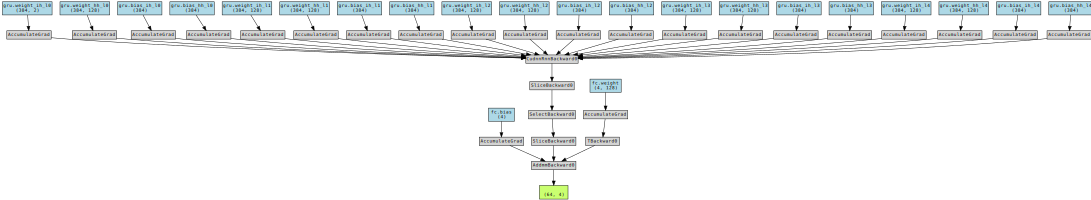

In [15]:
from torchviz import make_dot

netD = GRU_Model(input_size, hidden_size, num_layers, num_classes)
# Generate a random input tensor with shape (batch_size, sequence_length, input_size)
input_tensor = torch.randn(batch_size, sequence_length, input_size)

# If your model is on GPU, move the input tensor to GPU as well
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netD = netD.to(device)
input_tensor = input_tensor.to(device)

# Forward pass and visualize
out = netD(input_tensor)
make_dot(out, params=dict(list(netD.named_parameters())))

In [15]:
model = GRU_Model(input_size, hidden_size, num_layers, num_classes).to(device)

In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [17]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, patience):
    train_losses = []
    valid_losses = []
    best_loss = float('inf')
    best_epoch = 0
    n_no_improvement = 0
    n_total_steps = len(train_loader)
    model_path = 'Kia_Lisa1.pt'  # Path to save the model

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    for epoch in range(num_epochs):
        # Training
        train_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Train: Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {loss.item():.4f}')

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        valid_loss = 0.0
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

            valid_loss /= len(valid_loader)
            valid_losses.append(valid_loss)

            print(f'Valid: Epoch [{epoch + 1}/{num_epochs}], Loss: {valid_loss:.4f}')

            if valid_loss < best_loss:
                best_loss = valid_loss
                best_epoch = epoch
                n_no_improvement = 0

                # Save the model
                torch.save(model.state_dict(), model_path)

            else:
                n_no_improvement += 1

            if n_no_improvement >= patience:
                print(f'Early stopping: no improvement for {patience} epochs.')
                break

    return train_losses, valid_losses, best_loss, best_epoch

In [19]:
#train_losses, valid_losses, best_loss, best_epoch = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=500, patience=10)

Train: Epoch [1/500], Step [100/147], Loss: 0.0555
Valid: Epoch [1/500], Loss: 0.0768
Train: Epoch [2/500], Step [100/147], Loss: 0.0569
Valid: Epoch [2/500], Loss: 0.0727
Train: Epoch [3/500], Step [100/147], Loss: 0.0203
Valid: Epoch [3/500], Loss: 0.0670
Train: Epoch [4/500], Step [100/147], Loss: 0.1818
Valid: Epoch [4/500], Loss: 0.3680
Train: Epoch [5/500], Step [100/147], Loss: 0.2248
Valid: Epoch [5/500], Loss: 0.0909
Train: Epoch [6/500], Step [100/147], Loss: 0.0317
Valid: Epoch [6/500], Loss: 0.0472
Train: Epoch [7/500], Step [100/147], Loss: 0.0779
Valid: Epoch [7/500], Loss: 0.0825
Train: Epoch [8/500], Step [100/147], Loss: 0.0177
Valid: Epoch [8/500], Loss: 0.0581
Train: Epoch [9/500], Step [100/147], Loss: 0.0718
Valid: Epoch [9/500], Loss: 0.0389
Train: Epoch [10/500], Step [100/147], Loss: 0.0264
Valid: Epoch [10/500], Loss: 0.0366
Train: Epoch [11/500], Step [100/147], Loss: 0.0133
Valid: Epoch [11/500], Loss: 0.0392
Train: Epoch [12/500], Step [100/147], Loss: 0.023

In [18]:
def test_model(model, test_loader):
    model = model.to(device)  # Move the model to the appropriate device
    model.eval()
    with torch.no_grad():
        predictions = []
        labels = []
        for images, batch_labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.cpu().numpy())
            labels.append(batch_labels.cpu().numpy())

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        acc = 100.0 * np.sum(predictions == labels) / len(labels)
        print(f'Accuracy of the network on the test set: {acc:.4f} %')
        return predictions, labels

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GRU_Model(input_size, hidden_size, num_layers, num_classes)
model.load_state_dict(torch.load('Kia_Lisa1.pt', map_location=device))

# Move the test_loader to the appropriate device
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# Replace 'test_dataset' with your actual test dataset

test_predictions, test_labels = test_model(model, test_loader)

Accuracy of the network on the test set: 99.4536 %


In [20]:
y_pred = test_predictions
y_test = test_labels

In [21]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

print(cf_matrix)

[[497   0   0   6]
 [  0 503   0   0]
 [  0   1 503   0]
 [  4   0   0 499]]


In [24]:
def plot_confusion_matrix_with_percentages(y_test, y_pred, labels):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Convert the counts to percentages along rows (category-wise percentages)
    row_sums = cm.sum(axis=1)
    cm_percentages = cm / row_sums[:, np.newaxis] * 100
    
    # Create a heatmap with seaborn
    plt.figure(figsize=(8, 7))

    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    for i in range(len(cm)):
        for j in range(len(cm)):
            # Add actual numbers as text in the center of each cell
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', fontsize=16, fontweight='bold', color='black')
            # Add percentages as text on top of the actual numbers
            plt.text(j + 0.5, i + 0.65, f'{cm_percentages[i, j]:.2f}%', ha='center', va='center', fontsize=16, fontweight='bold', color='black')

    # Create the heatmap without showing the color bar
        sns.heatmap(cm, annot=False, cmap="Pastel2", cbar=False)

    # Add axis labels and title
    plt.xlabel("True Labels", fontweight="bold", fontsize=19, color='darkblue')
    plt.ylabel("Predicted Labels", fontweight="bold", fontsize=19, color='darkblue')

    # Set custom tick labels for x and y axes
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    
    # Manually set the color for the "Normal" label
    x_ticks = plt.gca().get_xticklabels()
    x_ticks[labels.index("Attack Free")].set_color('Green')
    y_ticks = plt.gca().get_yticklabels()
    y_ticks[labels.index("Attack Free")].set_color('Green')
    
    # Add a red square box around "DoS," "Fuzz," and "Replay" labels
    rect = plt.Rectangle((labels.index("DoS") - 0.02, labels.index("DoS") - 0.02), 3, 3, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)

    plt.show()

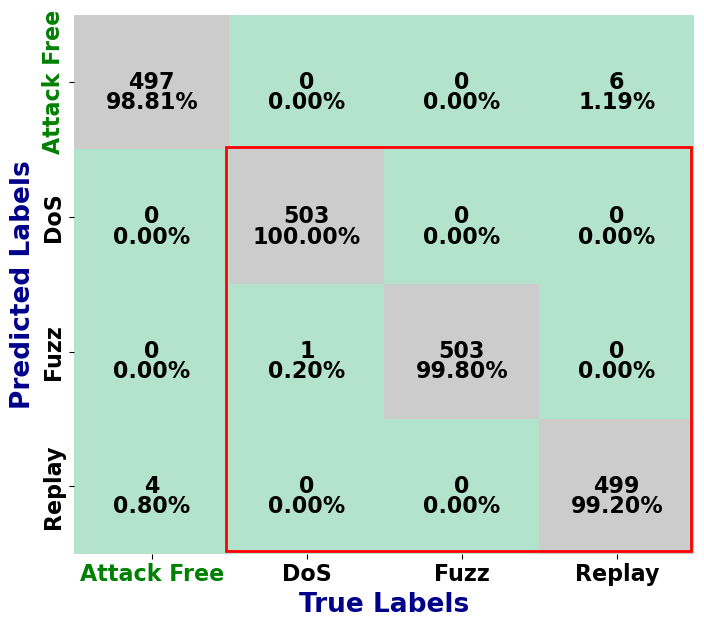

In [25]:
labels = ["Attack Free", "DoS", "Fuzz", "Replay"]
plot_confusion_matrix_with_percentages(y_test, y_pred, labels)

In [26]:
from sklearn.metrics import classification_report
class_names = ["Attack Free", "DoS", "Fuzz", "Replay"]
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 Attack Free       0.99      0.99      0.99       503
         DoS       1.00      1.00      1.00       503
        Fuzz       1.00      1.00      1.00       504
      Replay       0.99      0.99      0.99       503

    accuracy                           0.99      2013
   macro avg       0.99      0.99      0.99      2013
weighted avg       0.99      0.99      0.99      2013



In [27]:
def calculate_metrics(y_true, y_pred):
    total_samples = len(y_true)
    total_negative_samples = 0
    false_alarms = 0
    incorrect_samples = 0

    for true_label, predicted_label in zip(y_true, y_pred):
        if true_label != predicted_label:
            incorrect_samples += 1

        if true_label == 0:
            total_negative_samples += 1
            if predicted_label == 1:
                false_alarms += 1

    error_rate = incorrect_samples / total_samples
    false_alarm_rate = false_alarms / total_negative_samples if total_negative_samples != 0 else 0

    print("Error Rate:", error_rate)
    print("False Alarm Rate:", false_alarm_rate)

In [28]:
calculate_metrics(y_test, y_pred)

Error Rate: 0.00546448087431694
False Alarm Rate: 0.0


ROC AUC score: 0.9963562986372734


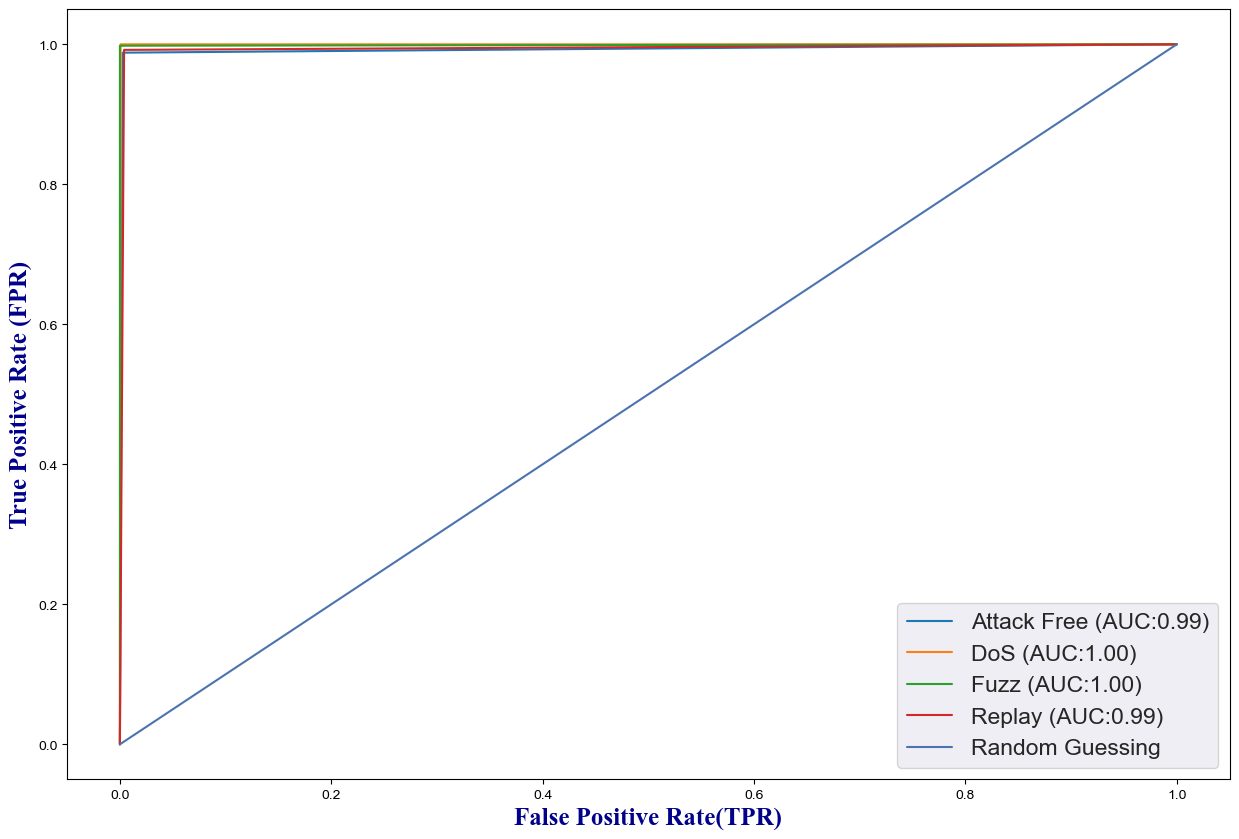

In [29]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Attack Free", "DoS", "Fuzz", "Replay"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(font_scale=1.5) #edited as suggested

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

c_ax.set_xlabel('False Positive Rate(TPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
c_ax.set_ylabel('True Positive Rate (FPR)', fontname="Times New Roman", size=18, fontweight="bold", color='darkblue')
#c_ax.text(0.16, -0.22, 'Fig. 6. (c) RUC Score CNN Multiclass Class Classification', fontname="Times New Roman",fontsize=25,fontweight="bold")
c_ax.legend(loc="lower right")

# Test On Lower Injection

In [30]:
Kia_V2_test_G = pd.read_csv(gabor_out + 'Kia_V2_test_G____.csv')
Kia_V2_val_G = pd.read_csv(gabor_out + 'Kia_V2_val_G____.csv')

In [31]:
X_Kia_test_G, y_Kia_test_G = data_pep(np.array(Kia_V2_test_G), feat_col_idx=[0, 1], target_col_idx=2, seq_len=100)
X_Kia_val_G, y_Kia_val_G = data_pep(np.array(Kia_V2_val_G), feat_col_idx=[0, 1], target_col_idx=2, seq_len=100)

In [32]:
val_dataset = MyDataset(X_Kia_val_G, y_Kia_val_G)
test_dataset = MyDataset(X_Kia_test_G, y_Kia_test_G)

In [33]:
valid_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [34]:
# Move the test_loader to the appropriate device
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# Replace 'test_dataset' with your actual test dataset

test_predictions, test_labels = test_model(model, test_loader)

Accuracy of the network on the test set: 68.8699 %


In [35]:
y_pred = test_predictions
y_test = test_labels

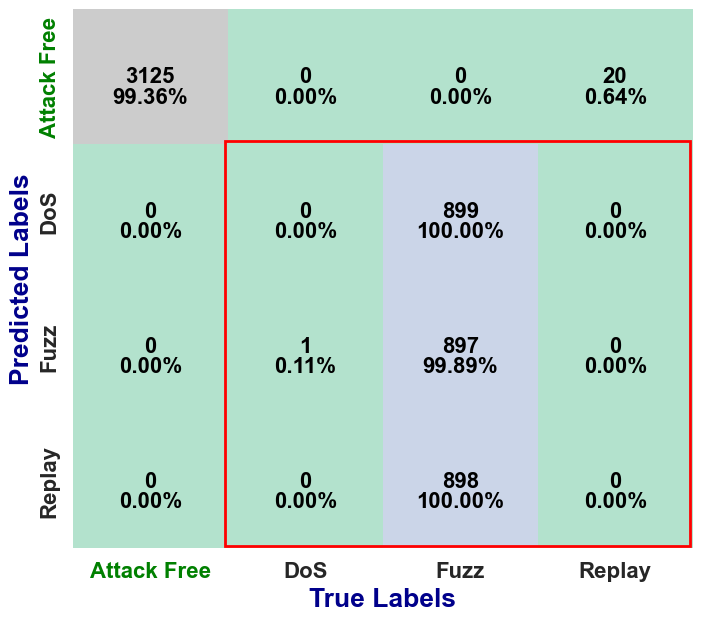

In [36]:
labels = ["Attack Free", "DoS", "Fuzz", "Replay"]
plot_confusion_matrix_with_percentages(y_test, y_pred, labels)

In [37]:
def plot_confusion_matrix_with_percentages_bin(y_test, y_pred, labels):
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Convert the counts to percentages along rows (category-wise percentages)
    row_sums = cm.sum(axis=1)
    cm_percentages = cm / row_sums[:, np.newaxis] * 100
    
    # Create a heatmap with seaborn
    plt.figure(figsize=(8, 7))

    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    # Plot the confusion matrix as a heatmap with annotations for both numbers and percentages
    for i in range(len(cm)):
        for j in range(len(cm)):
            # Add actual numbers as text in the center of each cell
            plt.text(j + 0.5, i + 0.5, str(cm[i, j]), ha='center', va='center', fontsize=16, fontweight='bold', color='black')
            # Add percentages as text on top of the actual numbers
            plt.text(j + 0.5, i + 0.65, f'{cm_percentages[i, j]:.2f}%', ha='center', va='center', fontsize=16, fontweight='bold', color='black')

    # Create the heatmap without showing the color bar
    sns.heatmap(cm, annot=False, cmap="Pastel2", cbar=False)

    # Add axis labels and title
    plt.xlabel("True Labels", fontweight="bold", fontsize=19, color='darkblue')
    plt.ylabel("Predicted Labels", fontweight="bold", fontsize=19, color='darkblue')

    # Set custom tick labels for x and y axes
    plt.xticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    plt.yticks(np.arange(len(labels)) + 0.5, labels, fontweight="bold", fontsize=16)
    
    # Manually set the color for the "Normal" label
    x_ticks = plt.gca().get_xticklabels()
    x_ticks[labels.index("Attack Free")].set_color('Green')
    y_ticks = plt.gca().get_yticklabels()
    y_ticks[labels.index("Attack Free")].set_color('Green')
    
    x_ticks = plt.gca().get_xticklabels()
    x_ticks[labels.index("Attack")].set_color('Red')
    y_ticks = plt.gca().get_yticklabels()
    y_ticks[labels.index("Attack")].set_color('Red')


    plt.show()

In [38]:
y_pred_bin = y_pred
y_test_bin = y_test

In [39]:
# Replace values greater than 0 with 1
y_pred_bin[y_pred_bin > 0] = 1
# Replace values greater than 0 with 1
y_test_bin[y_test_bin > 0] = 1

In [40]:
# Define labels for the confusion matrix
labels = ["Attack Free", "Attack"]

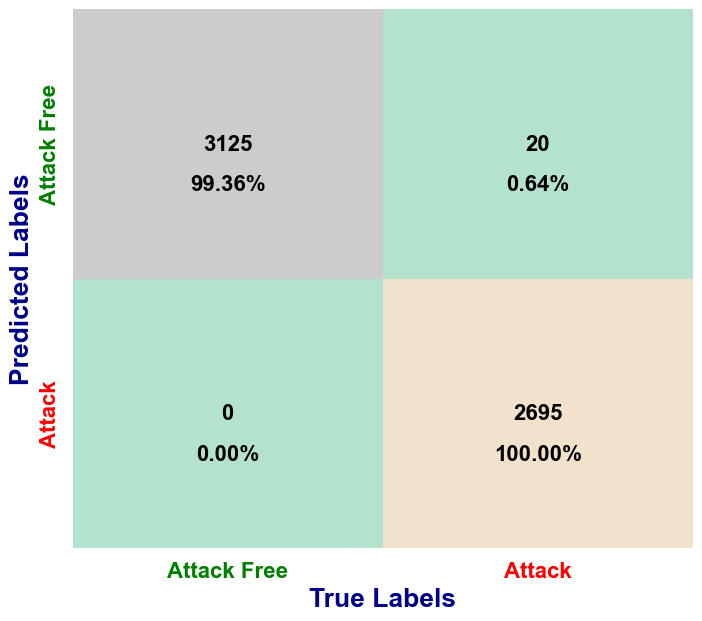

In [41]:
plot_confusion_matrix_with_percentages_bin(y_test_bin, y_pred_bin, labels)

In [42]:
class_names = ["Attack Free", "Attack"]
print(classification_report(y_pred_bin, y_test_bin, target_names=class_names))
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_bin, y_pred_bin)
print(f'ROC AUC Score: {roc_auc:.2f}')

              precision    recall  f1-score   support

 Attack Free       0.99      1.00      1.00      3125
      Attack       1.00      0.99      1.00      2715

    accuracy                           1.00      5840
   macro avg       1.00      1.00      1.00      5840
weighted avg       1.00      1.00      1.00      5840

ROC AUC Score: 1.00


In [43]:
calculate_metrics(y_pred_bin, y_test_bin)

Error Rate: 0.003424657534246575
False Alarm Rate: 0.0
